In [4]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [5]:
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lohitaksha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Lohitaksha\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [11]:
from datasets import load_dataset
ds = load_dataset("Jinyan1/PolitiFact")
df_mf = ds['MF'].to_pandas(); df_mf['label'] = 'fake'
df_hf = ds['HF'].to_pandas(); df_hf['label'] = 'fake'
df_mr = ds['MR'].to_pandas(); df_mr['label'] = 'real'
df_hr = ds['HR'].to_pandas(); df_hr['label'] = 'real'
df_all = pd.concat([df_mf, df_hf, df_mr, df_hr], ignore_index=True)
df_all = df_all.dropna(subset=['text'])
df_all = df_all[df_all['text'].str.strip().astype(bool)]
df_all['clean_text'] = df_all['text'].apply(clean_text)

In [12]:
X = df_all['clean_text']
y = df_all['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [13]:
tfidf = TfidfVectorizer(stop_words='english', max_df=0.7, min_df=5, ngram_range=(1, 2), max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Grid search for Logistic Regression
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
grid = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy')
grid.fit(X_train_tfidf, y_train)


GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=1000),
             param_grid={'C': [0.01, 0.1, 1, 10, 100]}, scoring='accuracy')

Best C value: {'C': 10}
Accuracy: 0.8558

Classification Report:
               precision    recall  f1-score   support

        real       0.80      0.82      0.81        39
        fake       0.89      0.88      0.88        65

    accuracy                           0.86       104
   macro avg       0.85      0.85      0.85       104
weighted avg       0.86      0.86      0.86       104



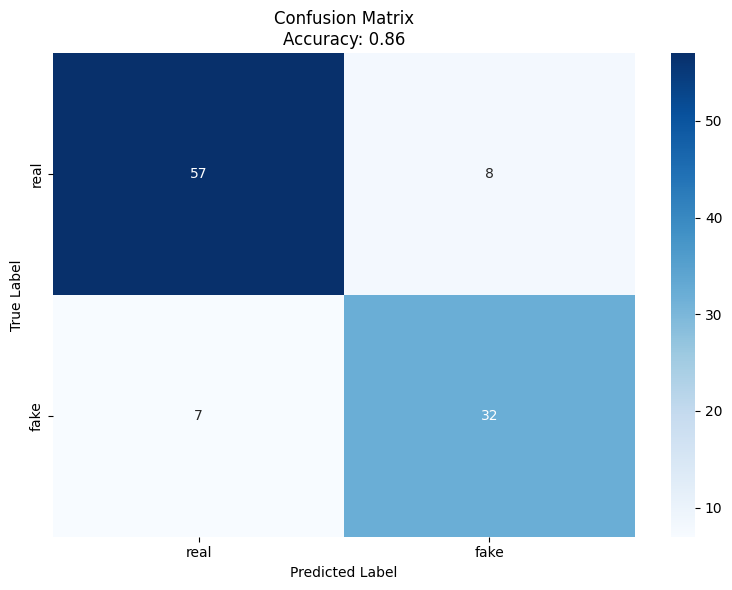

In [14]:
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred, labels=["real", "fake"])
report = classification_report(y_test, y_pred, target_names=["real", "fake"])

print("Best C value:", grid.best_params_)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", report)

# Confusion matrix plot
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["real", "fake"], yticklabels=["real", "fake"])
plt.title(f"Confusion Matrix\nAccuracy: {accuracy:.2f}")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()
